## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Missing values

In [4]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
test['age_approx'].fillna(train['age_approx'].mean(), inplace=True)
# anatom_site_general_challenge (NaN)
train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [5]:
### Label ecoding
enc = LabelEncoder()
train['sex_enc'] = enc.fit_transform(train['sex'].astype('str'))
test['sex_enc'] = enc.transform(test['sex'].astype('str'))

### One-hot ecoding
# train = pd.concat([train, pd.get_dummies(train['sex'], prefix='sex_enc', drop_first=True)], axis=1)
# test = pd.concat([test, pd.get_dummies(test['sex'], prefix='sex_enc', drop_first=True)], axis=1)

### Mean ecoding
# Sex
train['sex_mean'] = train['sex'].map(train.groupby(['sex'])['target'].mean())
test['sex_mean'] = test['sex'].map(train.groupby(['sex'])['target'].mean())


# External features
train_img_ft = pd.read_csv('../input/landscape/TrainSuperTab.csv')
test_img_ft = pd.read_csv('../input/landscape/TestSuperTab.csv')
ext_fts = ['V1', 'V2', 'V3', 'V4','V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 
           'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25',
           'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']
for ft in ext_fts:
    train[ft] = train_img_ft[ft]
    test[ft] = test_img_ft[ft]

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,...,1.835102,1.428571,1.176471,0.368451,24.984602,1.309416,0.272855,0.098885,52.594848,0.428426
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,...,1.301577,1.666667,1.095238,0.391409,25.587810,1.240345,0.317342,0.125999,57.991760,0.430091
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,...,1.475337,1.531477,0.581197,0.209879,14.387222,1.272196,0.410767,0.138850,56.623874,0.423386
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,...,2.772424,1.000000,2.000000,0.643102,47.842749,1.504529,0.830075,0.271822,46.900691,0.425073
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,...,1.358362,1.479167,1.100000,0.361749,23.899347,1.310327,0.357306,0.125601,57.289260,0.428426


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_enc,sex_mean,V1,V2,V3,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,ISIC_0052060,IP_3579794,male,70.0,NaN,1,0.021231,0.1024,14,13671.8750,...,1.899913,1.250000,0.949153,0.326860,24.660825,1.384345,0.830075,0.231371,51.690459,0.426753
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,1,0.021231,0.1024,9,8789.0625,...,1.482239,1.363636,0.615385,0.184831,13.580182,1.311702,0.556334,0.186888,54.321052,0.438307
2,ISIC_0058510,IP_7960270,female,55.0,torso,0,0.013766,0.1024,5,4882.8125,...,1.354060,1.666667,1.250000,0.480622,29.233718,1.236259,0.409636,0.171080,57.767034,0.425073
3,ISIC_0073313,IP_6375035,female,50.0,torso,0,0.013766,0.1024,4,3906.2500,...,1.335321,1.734166,1.333333,0.626502,36.844012,1.253537,0.358360,0.153529,57.288517,0.436678
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0,0.013766,0.1024,3,2929.6875,...,1.232224,2.222222,1.226930,0.565741,30.575912,1.260437,0.384288,0.174129,59.508983,0.425073


# Model

In [6]:
features = ['age_approx', 'sex_mean']

ohe_features  = [col for col in train.columns if 'enc' in col]

features += ohe_features

# External features
features += ext_fts
print(features)

['age_approx', 'sex_mean', 'sex_enc', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'V29', 'V30', 'V31', 'V32', 'V33', 'V34', 'V35', 'V36', 'V37']


In [7]:
# Hyperparameter grid
param_grid = {
    'max_depth': list(range(2, 12, 2)),
    'learning_rate': list(np.logspace(np.log10(0.005), np.log10(0.5), base=10, num=1000)),
    'reg_alpha': list(np.linspace(0, 1)),
    'reg_lambda': list(np.linspace(0, 1)),
    'colsample_bytree': list(np.linspace(0.3, 1, 10)),
    'subsample': list(np.linspace(0.5, 1, 100)),
    'scale_pos_weight': list(np.linspace(1, (len(train[train['target'] == 0]) / len(train[train['target'] == 1])), 10)),
}


skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)

def get_idxs():
    for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
        x_train = train[train['tfrecord'].isin(idxT)]
        x_valid = train[~train['tfrecord'].isin(idxT)]
        yield x_train.index, x_valid.index


# Model
model = XGBClassifier(n_estimators=300, random_state=SEED)

grid_search = RandomizedSearchCV(param_distributions=param_grid, estimator=model, scoring='roc_auc', 
                                 cv=iter(get_idxs()), n_jobs=-1, n_iter=100, verbose=1)
result = grid_search.fit(train[features], train['target'])

print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
params = result.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 66.3min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 75.7min finished


Best: 0.786617 using {'subsample': 0.5151515151515151, 'scale_pos_weight': 1.0, 'reg_lambda': 0.2040816326530612, 'reg_alpha': 0.18367346938775508, 'max_depth': 6, 'learning_rate': 0.018773471120366682, 'colsample_bytree': 0.5333333333333333}
0.772598 (0.008207) with: {'subsample': 0.7171717171717171, 'scale_pos_weight': 49.64231354642314, 'reg_lambda': 0.5918367346938775, 'reg_alpha': 0.36734693877551017, 'max_depth': 4, 'learning_rate': 0.023422900579365236, 'colsample_bytree': 0.45555555555555555}
0.719393 (0.017633) with: {'subsample': 0.51010101010101, 'scale_pos_weight': 43.56202435312025, 'reg_lambda': 0.6122448979591836, 'reg_alpha': 0.7755102040816326, 'max_depth': 8, 'learning_rate': 0.11650307053484622, 'colsample_bytree': 1.0}
0.739787 (0.023134) with: {'subsample': 0.9797979797979799, 'scale_pos_weight': 13.160578386605785, 'reg_lambda': 0.4081632653061224, 'reg_alpha': 0.36734693877551017, 'max_depth': 10, 'learning_rate': 0.12775485451762533, 'colsample_bytree': 0.533333

# Training

In [8]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0
model_list = []

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    model = XGBClassifier(**params, random_state=SEED)
    
    model.fit(x_train[features], y_train, eval_set=[(x_valid[features], y_valid)], eval_metric='auc', verbose=0)
    model_list.append(model)

    # Evaludation
    preds = model.predict_proba(train[features])[:, 1]
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = model.predict_proba(test[features])[:, 1]
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [9]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.773


,image_name,target,pred
0,ISIC_2637011,0,0.090669
1,ISIC_0015719,0,0.080347
2,ISIC_0052212,0,0.090430
3,ISIC_0068279,0,0.096609
4,ISIC_0074268,0,0.080533


,count,mean,std,min,25%,50%,75%,max
target,33126.0,0.017630,0.131603,0.000000,0.00000,0.000000,0.000000,1.000000
pred,33126.0,0.091125,0.017559,0.079871,0.08084,0.085123,0.094324,0.529882


# Feature importance

Fold: 1


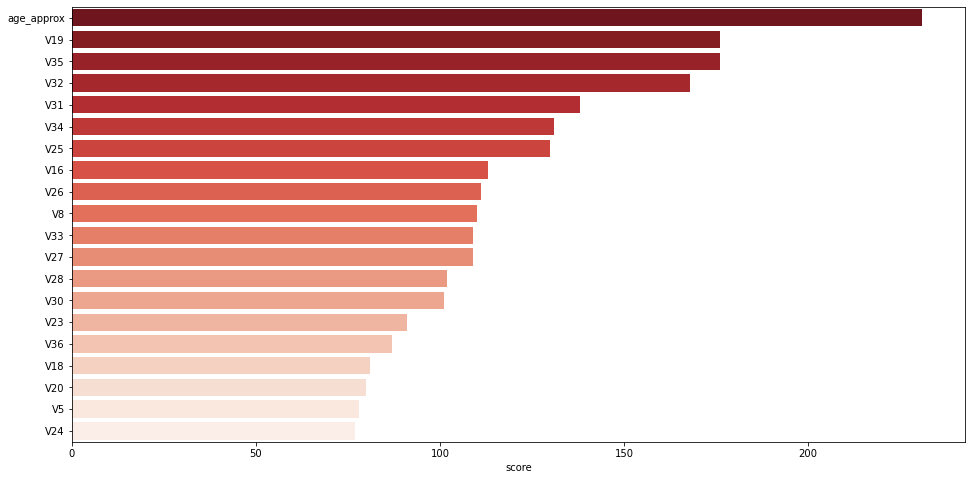

Fold: 2


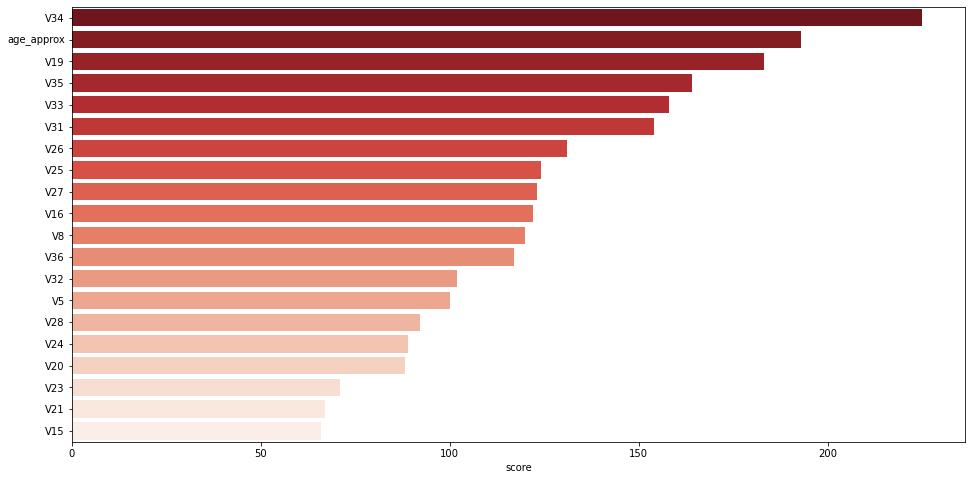

Fold: 3


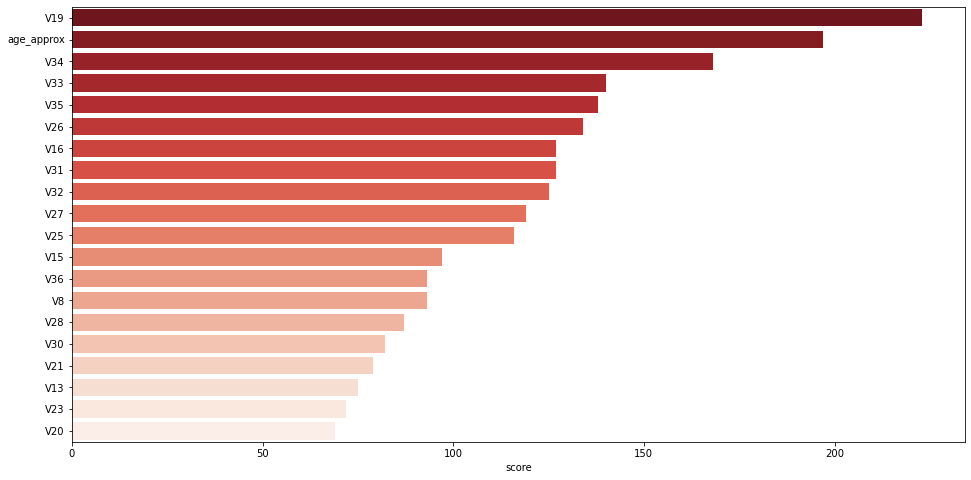

Fold: 4


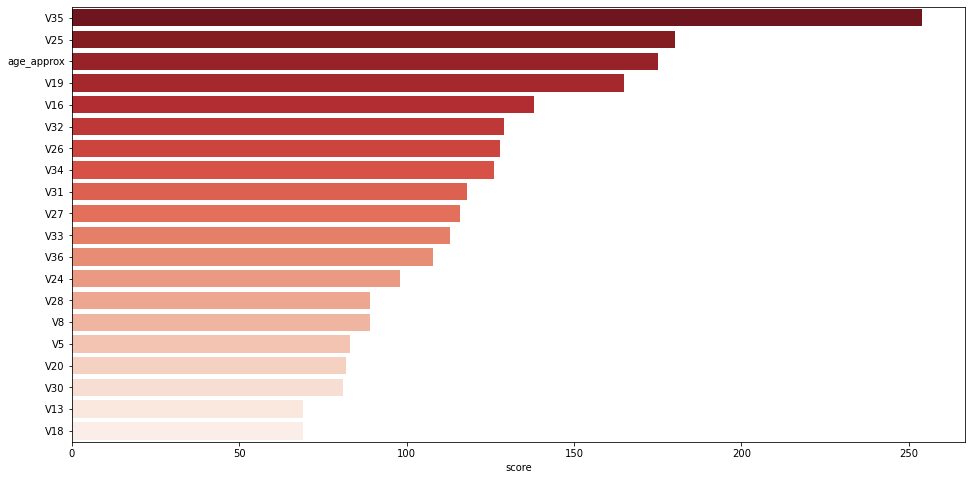

Fold: 5


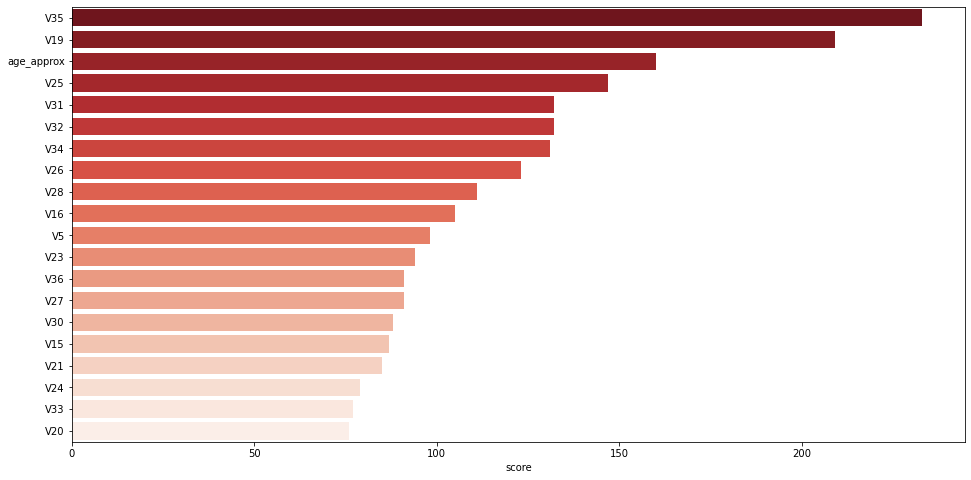

In [10]:
for n_fold, model in enumerate(model_list):
    print(f'Fold: {n_fold + 1}')
    feature_importance = model.get_booster().get_score(importance_type='weight')

    keys = list(feature_importance.keys())
    values = list(feature_importance.values())

    importance = pd.DataFrame(data=values, index=keys,
                              columns=['score']).sort_values(by='score',
                                                             ascending=False)
    plt.figure(figsize=(16, 8))
    sns.barplot(x=importance.score.iloc[:20],
                y=importance.index[:20],
                orient='h',
                palette='Reds_r')

    plt.show()

# Model evaluation

In [11]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.881810,0.775825,0.105985,0.878397,0.787054,0.884990,0.752194,0.883596,0.769585,0.881537,0.781183,0.880530,0.789106
Accuracy,0.982305,0.982962,-0.000657,0.982337,0.982927,0.982338,0.982922,0.982211,0.982966,0.982275,0.983163,0.982362,0.982830
Precision,0.800000,0.200000,0.600000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000
Recall,0.004304,0.003361,0.000943,0.006452,0.000000,0.006452,0.000000,0.000000,0.000000,0.002151,0.016807,0.006466,0.000000
F1-score,0.008556,0.006612,0.001945,0.012821,0.000000,0.012821,0.000000,0.000000,0.000000,0.004292,0.033058,0.012848,0.000000
Support,464.800000,119.200000,345.600000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,465.000000,119.000000,464.000000,120.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.881810,0.775825,0.105985,0.878397,0.787054,0.884990,0.752194,0.883596,0.769585,0.881537,0.781183,0.880530,0.789106
male,0.877188,0.763912,0.113277,0.876242,0.768170,0.875214,0.759097,0.884135,0.722027,0.880798,0.767476,0.869553,0.802788
female,0.883965,0.780944,0.103022,0.876610,0.807804,0.893600,0.735930,0.880198,0.807916,0.878059,0.793802,0.891360,0.759266
head/neck,0.846443,0.730721,0.115722,0.845842,0.746259,0.826864,0.771597,0.881194,0.602483,0.845132,0.784925,0.833183,0.748341
upper extremity,0.885647,0.778609,0.107039,0.893389,0.774678,0.884123,0.793098,0.881340,0.793311,0.890798,0.748514,0.878587,0.783442
lower extremity,0.823613,0.709065,0.114548,0.804578,0.721348,0.838633,0.595357,0.823787,0.749517,0.812161,0.726523,0.838906,0.752578
torso,0.917264,0.821960,0.095304,0.910030,0.846628,0.925808,0.785062,0.914735,0.838062,0.920956,0.811687,0.914791,0.828362
0 <= age < 26,0.885716,0.754029,0.131688,0.867035,0.753220,0.873381,0.686768,0.885441,0.788690,0.879249,0.804929,0.923477,0.736536
26 <= age < 40,0.864197,0.749205,0.114992,0.864417,0.746376,0.861529,0.806770,0.865942,0.725296,0.862568,0.687333,0.866530,0.780253


# Adversarial Validation

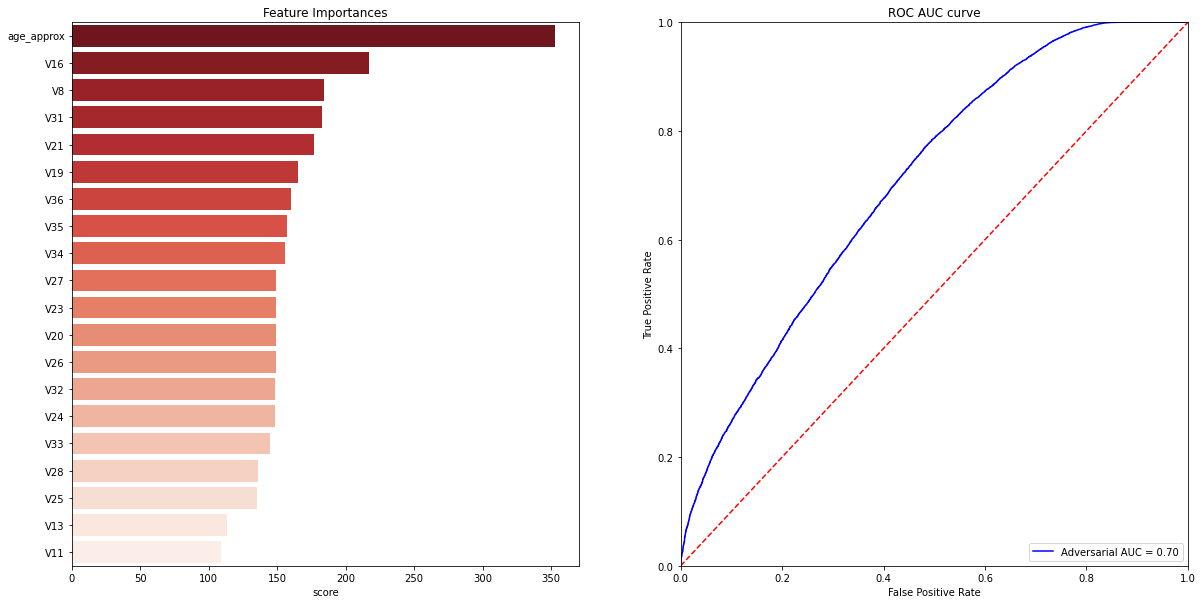

In [12]:
### Adversarial set
adv_train = train.copy()
adv_test = test.copy()
adv_train['dataset'] = 1
adv_test['dataset'] = 0

x_adv = pd.concat([adv_train, adv_test], axis=0)
y_adv = x_adv['dataset']

### Adversarial model
model_adv = XGBClassifier(**params, random_state=SEED)

model_adv.fit(x_adv[features], y_adv, eval_metric='auc', verbose=0)


### Preds
preds = model_adv.predict_proba(x_adv[features])[:, 1]


### Plot feature importance and ROC AUC curve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Feature importance
feature_importance = model_adv.get_booster().get_score(importance_type='weight')

keys = list(feature_importance.keys())
values = list(feature_importance.values())

importance = pd.DataFrame(data=values, index=keys,
                          columns=['score']).sort_values(by='score',
                                                         ascending=False)

ax1.set_title('Feature Importances')
sns.barplot(x=importance.score.iloc[:20],
            y=importance.index[:20],
            orient='h',
            palette='Reds_r',
            ax=ax1)

# Plot ROC AUC curve
fpr_train, tpr_train, _ = roc_curve(y_adv, preds)
roc_auc_train = auc(fpr_train, tpr_train)

ax2.set_title('ROC AUC curve')
ax2.plot(fpr_train, tpr_train, color='blue', label='Adversarial AUC = %0.2f' % roc_auc_train)
ax2.legend(loc = 'lower right')
ax2.plot([0, 1], [0, 1],'r--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.show()

# Visualize predictions

In [13]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 3
Train positive correct predictions: 3
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.088750,0.090669,0.088823,0.086054,0.088412,0.089788
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.080645,0.080347,0.080564,0.081184,0.080822,0.080308
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.089955,0.091646,0.087908,0.090005,0.089784,0.090430
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.097001,0.096609,0.096508,0.101751,0.094695,0.095441
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.080795,0.080533,0.080666,0.080855,0.080895,0.081027
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.080815,0.080574,0.080747,0.081077,0.080712,0.080963
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.080815,0.080758,0.080706,0.080639,0.081096,0.080873
7,ISIC_0075663,female,35.0,torso,unknown,0,0.095615,0.093332,0.100362,0.091286,0.095344,0.097750
8,ISIC_0075914,male,30.0,torso,unknown,0,0.080717,0.080598,0.080676,0.080855,0.080683,0.080772
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.082573,0.080455,0.081612,0.085105,0.083393,0.082298


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.081297,0.080533,0.080737,0.083060,0.081051,0.081104
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.157240,0.143299,0.123250,0.168252,0.167939,0.183460
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.104752,0.105585,0.103715,0.095787,0.114896,0.103776
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.098391,0.093703,0.101163,0.106052,0.099589,0.091446
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.094322,0.096736,0.092231,0.091031,0.091529,0.100085
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.126592,0.152824,0.106823,0.137275,0.131036,0.105002
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.100981,0.117386,0.103502,0.099108,0.088345,0.096565
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.130473,0.159679,0.099606,0.147126,0.118222,0.127732
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.237621,0.272384,0.241466,0.273290,0.158717,0.242244
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.083464,0.088275,0.083241,0.082823,0.081613,0.081367


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
4567,ISIC_1473522,female,75.0,torso,melanoma,1,0.586741,0.618337,0.680607,0.413578,0.529882,0.691303
24825,ISIC_7536704,male,75.0,torso,melanoma,1,0.566614,0.626684,0.653016,0.424463,0.504844,0.624065
29764,ISIC_9000824,male,80.0,torso,melanoma,1,0.565433,0.627427,0.658467,0.427296,0.504844,0.609130


# Visualize test predictions

In [14]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.097206,0.097588,0.099235,0.101247,0.094862,0.093096
1,ISIC_0052349,male,40.0,lower extremity,0.099752,0.099612,0.098050,0.097002,0.093036,0.111062
2,ISIC_0058510,female,55.0,torso,0.080465,0.080347,0.080458,0.080648,0.080402,0.080471
3,ISIC_0073313,female,50.0,torso,0.080103,0.080125,0.080253,0.080160,0.080101,0.079876
4,ISIC_0073502,female,45.0,lower extremity,0.080173,0.080396,0.080356,0.080064,0.080173,0.079876
5,ISIC_0074618,male,50.0,lower extremity,0.091166,0.091718,0.091885,0.088675,0.092908,0.090644
6,ISIC_0076801,male,45.0,upper extremity,0.105473,0.112416,0.109300,0.101042,0.100508,0.104101
7,ISIC_0077586,male,50.0,lower extremity,0.080186,0.080461,0.080356,0.080064,0.080173,0.079876
8,ISIC_0082004,female,45.0,torso,0.080173,0.080396,0.080356,0.080064,0.080173,0.079876
9,ISIC_0082785,male,65.0,lower extremity,0.094426,0.098094,0.099159,0.090550,0.093968,0.090361


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

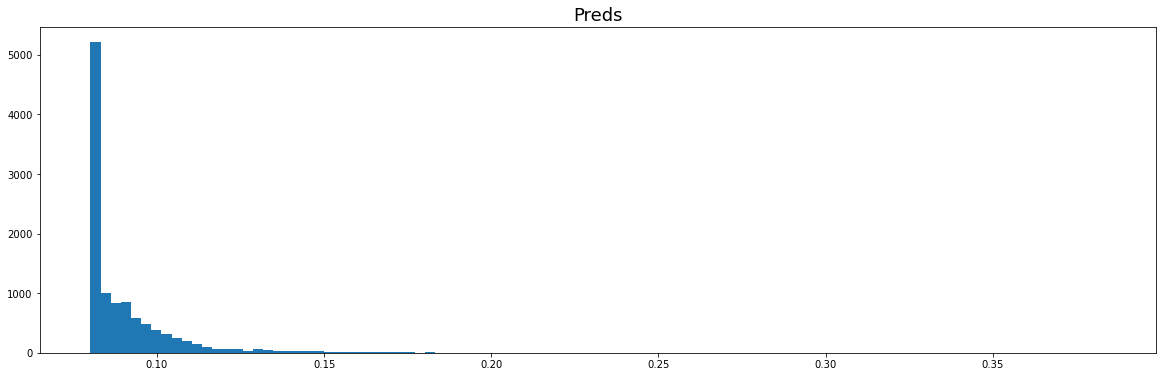

,image_name,target
0,ISIC_0052060,0.097206
1,ISIC_0052349,0.099752
2,ISIC_0058510,0.080465
3,ISIC_0073313,0.080103
4,ISIC_0073502,0.080173
5,ISIC_0074618,0.091166
6,ISIC_0076801,0.105473
7,ISIC_0077586,0.080186
8,ISIC_0082004,0.080173
9,ISIC_0082785,0.094426


,target
count,10982.000000
mean,0.090274
std,0.016412
min,0.080083
25%,0.080499
50%,0.083749
75%,0.093815
max,0.383600


In [15]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)